In [2]:
# To combine all predictions into a master predictions json file 
import json
from pathlib import Path

# Note - because we don't have all the images, we would have to sort through the exported docs folder
runs_root = Path("runs")
output_file = "predictions_dict_master.json"

# Master predictions list
master_predictions = []

# Loop through files matching the pattern
for json_file in sorted(runs_root.glob("*/predictions_dict_*.json")):
    with open(json_file, "r") as f:
        data = json.load(f)
        if "predictions" in data:
            master_predictions.extend(data["predictions"])  # Concatenate predictions!
        else:
            print(f"{json_file} missing 'predictions' key")

# Write the combined predictions to a new file
with open(output_file, "w") as f:
    json.dump({"predictions": master_predictions}, f, indent=2)

print(f"Combined {len(master_predictions)} predictions into {output_file}")

Combined 57243 predictions into predictions_dict_master.json


In [14]:
# Let's see if we can access the prediction for on image as an example for planning
master_json = "predictions_dict_master.json"

with open(master_json, "r") as f:
    data = json.load(f)
    json_string = json.dumps(data['predictions'][0], indent=3)

print(json_string)

{
   "filepath": "images/batch_0/2024-02-01_16-41-42--SYEW0714.JPG",
   "latitude": 41.906782,
   "longitude": -87.651927,
   "classifications": {
      "classes": [
         "f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank",
         "e2895ed5-780b-48f6-8a11-9e27cb594511;;;;;;vehicle",
         "86f5b978-4f30-40cc-bd08-be9e3fba27a0;mammalia;rodentia;sciuridae;sciurus;carolinensis;eastern gray squirrel",
         "aaf3b049-36e6-46dd-9a07-8a580e9618b7;mammalia;carnivora;canidae;canis;latrans;coyote",
         "5c7ce479-8a45-40b3-ae21-7c97dfae22f5;mammalia;cetartiodactyla;cervidae;odocoileus;virginianus;white-tailed deer"
      ],
      "scores": [
         0.9701787829399109,
         0.005642350763082504,
         0.004442729987204075,
         0.003875098889693618,
         0.002647292334586382
      ]
   },
   "detections": [
      {
         "category": "3",
         "label": "vehicle",
         "conf": 0.010134803131222725,
         "bbox": [
            0.30498531460762024,
      

In [58]:
# Let's see if we can access the prediction for each image


# Function for pairing classification and score
def get_high_score_classes(scores, classes, threshold=0.5):
    return [{"score": f'{score:.2f}', "class": cls} for score, cls in zip(scores, classes) if score > threshold]

# Function for pairing detection and score
def get_high_conf_detections(detections, target_label, threshold= 0.5):
    return [(f'{det["conf"]:2f}', det["label"]) for det in detections if det["label"] == target_label and det["conf"] > threshold]

# Staged Configuration
master_json = "predictions_dict_master.json"
master_data = []

# Open and loop over json file
with open(master_json, "r") as f:
    data = json.load(f)
    for image in data["predictions"]:
        high_score_classes = get_high_score_classes(
            image["classifications"]["scores"],
            image["classifications"]["classes"],
            0.5
        )
        master_data.append({
            "imageName": image["filepath"].split("/")[2],
            "nDetections_animal": len(get_high_conf_detections(image["detections"], "animal", 0.5)),
            "nDetections_human": len(get_high_conf_detections(image["detections"], "human", 0.5)),
            "nDetections_vehicle": len(get_high_conf_detections(image["detections"], "vehicle", 0.5)),
            "nClassifications": len(high_score_classes),
            "highScoreClasses": high_score_classes

        })
        
print(master_data[0:1])
    

[{'imageName': '2024-02-01_16-41-42--SYEW0714.JPG', 'nDetections_animal': 0, 'nDetections_human': 0, 'nDetections_vehicle': 0, 'nClassifications': 1, 'highScoreClasses': [{'score': '0.97', 'class': 'f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank'}]}]


In [69]:
# When ready, convert the list of dicts to a dataframe
import pandas as pd

# Create Dataframe
df = pd.DataFrame(master_data)

# Check Quality
print(f'{len(df)} Images in Dataset')
print(" Dataset Head ")
print(df.head())

57243 Images in Dataset
 Dataset Head 
                                           imageName  nDetections_animal  \
0                  2024-02-01_16-41-42--SYEW0714.JPG                   0   
1  2024-01-30_Learnin_platform_camera_test--SYFW0...                   0   
2                  2024-02-01_16-41-42--SYEW0169.JPG                   0   
3    2024-01-31_LearningPlatformBeaver--SYFW0039.JPG                   0   
4    2024-01-31_LearningPlatformBeaver--SYFW0023.JPG                   0   

   nDetections_human  nDetections_vehicle  nClassifications  \
0                  0                    0                 1   
1                  0                    0                 1   
2                  0                    0                 1   
3                  0                    0                 1   
4                  0                    0                 1   

                                    highScoreClasses  
0  [{'score': '0.97', 'class': 'f1856211-cfb7-4a5...  
1  [{'score': '

In [70]:
# Now let's explode the classes tuples so we have a row per high confidence class - noting that the counts are not per class but for total detection type in image
df2 = df.explode("highScoreClasses", ignore_index=True)

# Normalize to flatten the dicts
class_df = pd.json_normalize(df2["highScoreClasses"])

# remove original column and join back to the df
df2 = df.join(class_df).drop(columns=["highScoreClasses"])

print(df2.head())

                                           imageName  nDetections_animal  \
0                  2024-02-01_16-41-42--SYEW0714.JPG                   0   
1  2024-01-30_Learnin_platform_camera_test--SYFW0...                   0   
2                  2024-02-01_16-41-42--SYEW0169.JPG                   0   
3    2024-01-31_LearningPlatformBeaver--SYFW0039.JPG                   0   
4    2024-01-31_LearningPlatformBeaver--SYFW0023.JPG                   0   

   nDetections_human  nDetections_vehicle  nClassifications score  \
0                  0                    0                 1  0.97   
1                  0                    0                 1  0.98   
2                  0                    0                 1  1.00   
3                  0                    0                 1  0.99   
4                  0                    0                 1  1.00   

                                             class  
0  f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank  
1  f1856211-cfb7-4a5b-

In [ ]:
# Make a custom column
df2["simple_class"] = df2["class"].str.split(";").str[-1]

df2.head()

,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class
0,2024-02-01_16-41-42--SYEW0714.JPG,0,0,0,1,0.97,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
1,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,0,0,1,0.98,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
2,2024-02-01_16-41-42--SYEW0169.JPG,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
3,2024-01-31_LearningPlatformBeaver--SYFW0039.JPG,0,0,0,1,0.99,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
4,2024-01-31_LearningPlatformBeaver--SYFW0023.JPG,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank


In [76]:
# Save the df as a csv
df2.to_csv("classified_images.csv")

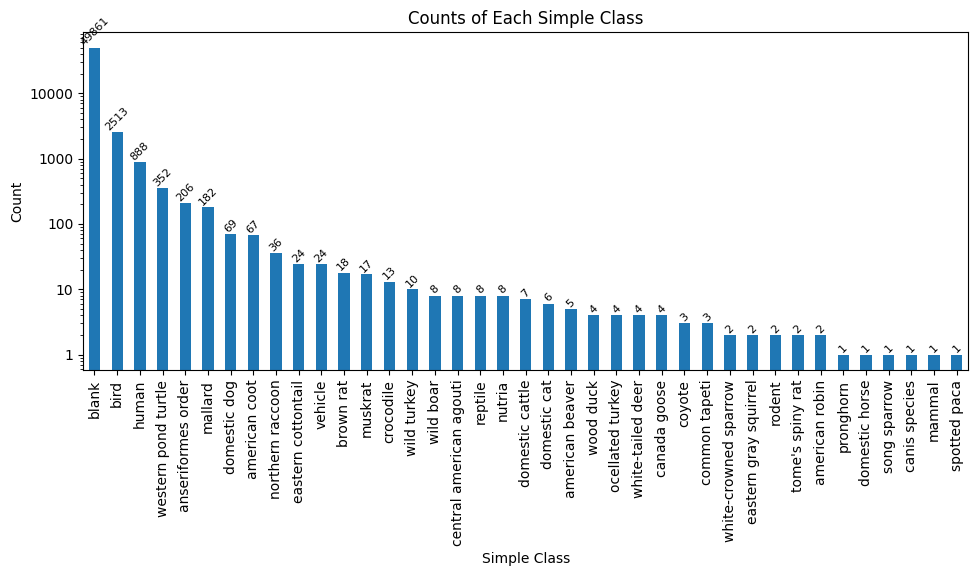

In [125]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Filter out a simple class
df3 = df2[~df2["simple_class"].isin([])]

# Count how many times each simple_class appears
counts = df3["simple_class"].value_counts()

# Plot bar graph
ax = counts.plot(kind="bar", figsize=(12,5))
plt.title("Counts of Each Simple Class")

# Configure y axis
plt.yscale("log")
plt.ylabel("Count")

# Format y-axis ticks as integers (not floats/scientific)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# Configure x axis
plt.xlabel("Simple Class")
plt.xticks(rotation=90, ha="center")

# Add count labels on top of each bar, rotated vertical
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-position: center of bar
        height,                             # y-position: top of bar
        f'{int(height)}',                   # text: integer count
        ha='center',
        va='bottom',
        rotation=45,
        fontsize=8
    )


# Display
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.show()


In [148]:
# Create a table of counts
counts_table = df3["simple_class"].value_counts().reset_index()
counts_table.columns = ["simple_class", "count"]

def format_pct(x):
    if x < 0.1: return f'{x:.3f}' 
    elif x < 1: return f'{x:.2f}' 
    else: return f'{x:.1f}'

counts_table["%"] = (counts_table["count"]/len(df3) * 100).map(format_pct)
counts_table.index = counts_table.index + 1

# Display the table
counts_table[:20]


,simple_class,count,%
1,blank,49861,87.1
2,bird,2513,4.4
3,human,888,1.6
4,western pond turtle,352,0.61
5,anseriformes order,206,0.36
6,mallard,182,0.32
7,domestic dog,69,0.12
8,american coot,67,0.12
9,northern raccoon,36,0.063
10,eastern cottontail,24,0.042


In [172]:
# Let's rejoin the test medias and predictions based on imageName

metadata = pd.read_csv("ur_test_medias.csv")
predicts = df3.copy()

print(" ======== df('METADATA') ======== ")
metadata.info()

print(" ======== df('PREDICTS') ======== ")
predicts.info()

 ======== df('METADATA') ======== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105163 entries, 0 to 105162
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   105163 non-null  object
 1   publicURL   105163 non-null  object
 2   fileName    105163 non-null  object
 3   folderName  105163 non-null  object
 4   imageName   105163 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB
 ======== df('PREDICTS') ======== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57243 entries, 0 to 57242
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   imageName            57243 non-null  object
 1   nDetections_animal   57243 non-null  int64 
 2   nDetections_human    57243 non-null  int64 
 3   nDetections_vehicle  57243 non-null  int64 
 4   nClassifications     57243 non-null  int64 
 5   score                54368 non-null  

In [181]:
# Merge them based on a column name (a join would be on the index and not appropriate in this case)
merged_df = pd.merge(metadata, predicts, on="imageName", how="inner")

print(len(predicts))
print(len(merged_df))
merged_df.tail()


57243
64229


,timestamp,publicURL,fileName,folderName,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class
64224,2024-06-27 08:52:36,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW2722.JPG,2024-06-27_UR011,2024-06-27_UR011--SYFW2722.JPG,3,0,0,1,0.83,446887df-3477-4f4a-a434-852f96ba48d9;reptilia;...,western pond turtle
64225,2024-06-27 08:52:37,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW2723.JPG,2024-06-27_UR011,2024-06-27_UR011--SYFW2723.JPG,3,0,0,1,0.89,446887df-3477-4f4a-a434-852f96ba48d9;reptilia;...,western pond turtle
64226,2024-06-27 08:52:02,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW2719.JPG,2024-06-27_UR011,2024-06-27_UR011--SYFW2719.JPG,5,0,0,1,0.67,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
64227,2024-06-27 08:52:02,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW2718.JPG,2024-06-27_UR011,2024-06-27_UR011--SYFW2718.JPG,5,0,0,0,NaN,NaN,NaN
64228,2024-06-27 08:51:31,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW2715.JPG,2024-06-27_UR011,2024-06-27_UR011--SYFW2715.JPG,3,0,0,1,0.70,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank


In [188]:
# Let's take a look at images where classifications is NaN
nan_class_df = merged_df[merged_df["nClassifications"] == 0 & merged_df["nDetections_animal"] == 0]

nan_class_df.head()
nan_class_df.to_csv("results/zero_class.csv")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().